# Multiplayer vs Singleplayer játékok osztályozása

## Probléma leírása

A videójátékok egyik alapvető jellemzője, hogy egyedül (singleplayer) vagy más játékosokkal együtt (multiplayer) játszhatók. Ez a tulajdonság fontos szerepet játszik a játékosok döntéseiben, ezért érdemes megvizsgálni, hogy automatizált módon előrejelezhető-e.

Ebben a munkában egy **felügyelt, bináris osztályozási problémát** vizsgálunk, amelynek célja annak meghatározása, hogy egy videójáték **multiplayer** vagy **singleplayer** jellegű-e.

## Célváltozó (Target)

A célváltozó egy bináris változó:

- `1` – a játék rendelkezik multiplayer (pl. online, co-op, PvP) funkcióval  
- `0` – a játék kizárólag singleplayer módban játszható

A címkét a játék kategóriái (categories) alapján határozzuk meg.

## Bemeneti jellemzők

A predikcióhoz az alábbi információkat használjuk fel:

- Szöveges leírások (`about_the_game`, `short_description`)
- Műfajok (genres)
- Címkék (tags)
- Egyéb alapvető metaadatok (pl. ár)

A szöveges adatokat természetesnyelv-feldolgozási módszerekkel, a strukturált adatokat bináris kódolással dolgozzuk fel.

## Alkalmazott módszerek

Az osztályozási feladat megoldására logisztikus regressziót és lineáris SVM modellt alkalmazunk, a teljesítményt pedig többek között **F1-score** és **konfúziós mátrix** segítségével értékeljük.


## Adatbetöltés

In [1]:
import pandas as pd
import numpy as np
import re
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt

DATA_DIR = Path(r"C:\Users\zalma\videogame-data-analysis\split")


# --- FŐ TÁBLA ---
game = pd.read_csv(DATA_DIR / "game.csv")

# -------------------------------
# Leírások
# -------------------------------
description = pd.read_csv(DATA_DIR / "description.csv")

# --- MŰFAJOK (genres) ---
game_genre = pd.read_csv(DATA_DIR / "game_genre.csv")
genres = pd.read_csv(DATA_DIR / "genres.csv")

# --- KATEGÓRIÁK (categories) ---
game_category = pd.read_csv(DATA_DIR / "game_category.csv")
categories = pd.read_csv(DATA_DIR / "categories.csv")

# --- CÍMKÉK (tags) ---
game_tag = pd.read_csv(DATA_DIR / "game_tag.csv")
tags = pd.read_csv(DATA_DIR / "tags.csv")

print("game shape:", game.shape)
print("description shape:", description.shape)
print("game_genre shape:", game_genre.shape, "| genres shape:", genres.shape)
print("game_category shape:", game_category.shape, "| categories shape:", categories.shape)
print("game_tag shape:", game_tag.shape, "| tags shape:", tags.shape)

print("\n--- game columns ---")
print(game.columns.tolist())

game.head()

game shape: (112855, 29)
description shape: (112855, 5)
game_genre shape: (112855, 2) | genres shape: (112855, 2)
game_category shape: (112855, 2) | categories shape: (112855, 2)
game_tag shape: (1116858, 2) | tags shape: (1116858, 3)

--- game columns ---
['appid', 'name', 'release_date', 'estimated_owners', 'required_age', 'price', 'dlc_count', 'num_recommendations', 'notes', 'website', 'metacritic_score', 'metacritic_url', 'num_achievements', 'user_score', 'score_rank', 'positive', 'negative', 'average_playtime_forever', 'average_playtime_2weeks', 'median_playtime_forever', 'median_playtime_2weeks', 'peak_ccu', 'discount', 'pct_pos_total', 'pct_pos_recent', 'num_reviews_total', 'num_reviews_recent', 'reviews', 'english']


,appid,name,release_date,estimated_owners,required_age,price,dlc_count,num_recommendations,notes,website,...,median_playtime_forever,median_playtime_2weeks,peak_ccu,discount,pct_pos_total,pct_pos_recent,num_reviews_total,num_reviews_recent,reviews,english
0,10,Counter-Strike,2000-11-01,10000000 - 20000000,0.0,9.99,0.0,149445.0,Includes intense violence and blood.,NaN,...,0.0,0.0,11703.0,NaN,96.0,95.0,149589.0,908.0,NaN,1.0
1,20,Team Fortress Classic,1999-04-01,5000000 - 10000000,0.0,4.99,0.0,6454.0,Includes intense violence and blood.,NaN,...,15.0,0.0,46.0,0.0,86.0,76.0,6482.0,56.0,NaN,1.0
2,30,Day of Defeat,2003-05-01,5000000 - 10000000,0.0,4.99,0.0,4032.0,NaN,http://www.dayofdefeat.com/,...,0.0,0.0,101.0,NaN,87.0,97.0,4038.0,36.0,NaN,1.0
3,40,Deathmatch Classic,2001-06-01,5000000 - 10000000,0.0,4.99,0.0,2113.0,NaN,NaN,...,7.0,0.0,4.0,NaN,81.0,95.0,2120.0,21.0,NaN,1.0
4,50,Half-Life: Opposing Force,1999-11-01,2000000 - 5000000,0.0,4.99,0.0,18908.0,NaN,NaN,...,161.0,36.0,87.0,NaN,95.0,95.0,18994.0,269.0,NaN,1.0


## Célváltozó létrehozása

Ebben a részben a játékok kategóriái alapján bináris célváltozót hozunk létre, amely azt jelöli, hogy egy játék rendelkezik-e multiplayer funkcióval. A kategóriák neveit felhasználva megkülönböztetjük a multiplayer és a kizárólag singleplayer játékokat.

In [2]:
appid_col = "appid"

cat_id_col = "catid"
cat_name_col = "name"

gc = game_category.merge(
    categories[[cat_id_col, cat_name_col]],
    on=cat_id_col,
    how="left"
)

def split_categories(s):
    if pd.isna(s):
        return []
    parts = re.split(r"[;,]", str(s))
    return [p.strip().lower() for p in parts if p.strip()]

gc["category_list"] = gc[cat_name_col].apply(split_categories)

multiplayer_keywords = [
    "multi-player", "multiplayer",
    "online pvp", "pvp",
    "local multiplayer",
    "co-op", "coop", "online co-op", "local co-op",
    "mmo", "massively multiplayer"
]

singleplayer_keywords = [
    "single-player", "singleplayer"
]

gc["is_multiplayer"] = gc["category_list"].apply(
    lambda lst: any(
        any(k in cat for k in multiplayer_keywords)
        for cat in lst
    )
).astype(int)

gc["is_singleplayer"] = gc["category_list"].apply(
    lambda lst: any(
        any(k in cat for k in singleplayer_keywords)
        for cat in lst
    )
).astype(int)

agg = (
    gc.groupby(appid_col)[["is_multiplayer", "is_singleplayer"]]
    .max()
    .reset_index()
)

agg["y_multiplayer"] = (agg["is_multiplayer"] == 1).astype(int)

labeled = agg[
    (agg["is_multiplayer"] == 1) | (agg["is_singleplayer"] == 1)
].copy()

df = game.merge(
    labeled[[appid_col, "y_multiplayer"]],
    on=appid_col,
    how="inner"
)

print("Labeled dataset shape:", df.shape)

print("\nTarget eloszlás (0 = singleplayer, 1 = multiplayer):")
print(df["y_multiplayer"].value_counts())

print("\nTarget eloszlás (%):")
print((df["y_multiplayer"].value_counts(normalize=True) * 100).round(2))

Labeled dataset shape: (104701, 30)

Target eloszlás (0 = singleplayer, 1 = multiplayer):
y_multiplayer
0    84825
1    19876
Name: count, dtype: int64

Target eloszlás (%):
y_multiplayer
0    81.02
1    18.98
Name: proportion, dtype: float64


## Szöveges leírások csatolása

Ebben a lépésben a játékokhoz tartozó szöveges leírásokat a `description` táblából az `appid` azonosító alapján csatoljuk a fő adathalmazhoz. A részletes és rövid leírásokat egyetlen szöveges mezőbe vonjuk össze, amelyet a későbbi természetesnyelv-feldolgozási lépések során használunk fel.


In [3]:
desc_cols = [
    "appid",
    "about_the_game",
    "short_description"
]

desc = description[desc_cols].copy()

desc["about_the_game"] = desc["about_the_game"].fillna("")
desc["short_description"] = desc["short_description"].fillna("")

desc["text"] = (
    desc["about_the_game"] + " " + desc["short_description"]
).str.strip()

df = df.merge(
    desc[["appid", "text"]],
    on="appid",
    how="left"
)

print("After description join:", df.shape)
print("\nMissing text values:", df["text"].isna().sum())

df[["appid", "text"]].head()

After description join: (104701, 31)

Missing text values: 0


,appid,text
0,10,Play the world's number 1 online action game. ...
1,20,One of the most popular online action games of...
2,30,Enlist in an intense brand of Axis vs. Allied ...
3,40,Enjoy fast-paced multiplayer gaming with Death...
4,50,Return to the Black Mesa Research Facility as ...


## Szöveg előtisztítás

Ebben a lépésben az összevont szöveges leírásokat előtisztítjuk a természetesnyelv-feldolgozás előtt. Az előfeldolgozás során eltávolítjuk az HTML tageket, URL-eket és speciális karaktereket, valamint egységesítjük a szöveget a későbbi vektorizáláshoz.


In [4]:
def clean_text(s: str) -> str:
    if not isinstance(s, str):
        return ""
    
    s = s.lower()
    s = re.sub(r"<[^>]+>", " ", s)
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"[^a-z0-9\s]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    
    return s

df["text"] = df["text"].fillna("")

df["text_clean"] = df["text"].apply(clean_text)

print("Üres text_clean sorok száma:", (df["text_clean"].str.len() == 0).sum())
df[["text", "text_clean"]].head(3)

Üres text_clean sorok száma: 207


,text,text_clean
0,Play the world's number 1 online action game. ...,play the world s number 1 online action game e...
1,One of the most popular online action games of...,one of the most popular online action games of...
2,Enlist in an intense brand of Axis vs. Allied ...,enlist in an intense brand of axis vs allied t...


## Baseline modell (csak szöveg)

Ebben a részben egy egyszerű baseline modellt tanítunk a tisztított szöveges leírások alapján.  
A szöveget TF-IDF vektorizáljuk, majd logisztikus regresszióval bináris osztályozást végzünk (multiplayer vs singleplayer).


Train size: 83760 | Test size: 20941
Train target %:
 y_multiplayer
0    81.02
1    18.98
Name: proportion, dtype: float64
Test target %:
 y_multiplayer
0    81.02
1    18.98
Name: proportion, dtype: float64

Classification report:
              precision    recall  f1-score   support

           0     0.9649    0.9523    0.9586     16966
           1     0.8072    0.8523    0.8292      3975

    accuracy                         0.9333     20941
   macro avg     0.8861    0.9023    0.8939     20941
weighted avg     0.9350    0.9333    0.9340     20941



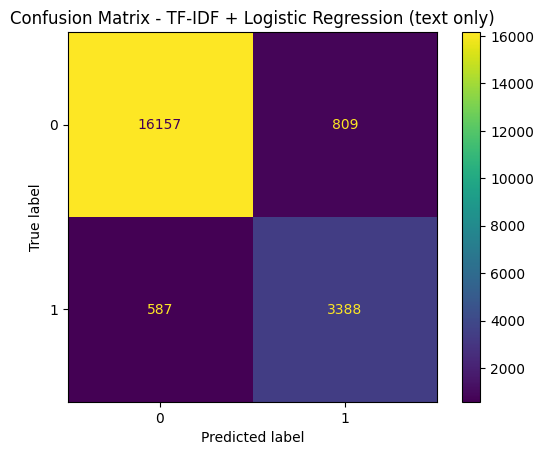

In [5]:
X = df["text_clean"]
y = df["y_multiplayer"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape[0], "| Test size:", X_test.shape[0])
print("Train target %:\n", (y_train.value_counts(normalize=True)*100).round(2))
print("Test target %:\n", (y_test.value_counts(normalize=True)*100).round(2))

text_clf = Pipeline(steps=[
    ("tfidf", TfidfVectorizer(
        max_features=50_000,
        ngram_range=(1, 2),
        min_df=5
    )),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        n_jobs=-1
    ))
])

text_clf.fit(X_train, y_train)
y_pred = text_clf.predict(X_test)

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=4))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix - TF-IDF + Logistic Regression (text only)")
plt.savefig('confusion_tf.png')
plt.show()

## Alternatív baseline: Lineáris SVM (csak szöveg)

Ebben a részben a korábbi TF-IDF szövegreprezentációt megtartva egy lineáris SVM modellt tanítunk.  
A lineáris SVM gyakran különösen jól teljesít nagy dimenziós, ritka (TF-IDF) bemeneteken.


Classification report (TF-IDF + LinearSVC):
              precision    recall  f1-score   support

           0     0.9608    0.9609    0.9608     16966
           1     0.8329    0.8327    0.8328      3975

    accuracy                         0.9365     20941
   macro avg     0.8969    0.8968    0.8968     20941
weighted avg     0.9365    0.9365    0.9365     20941



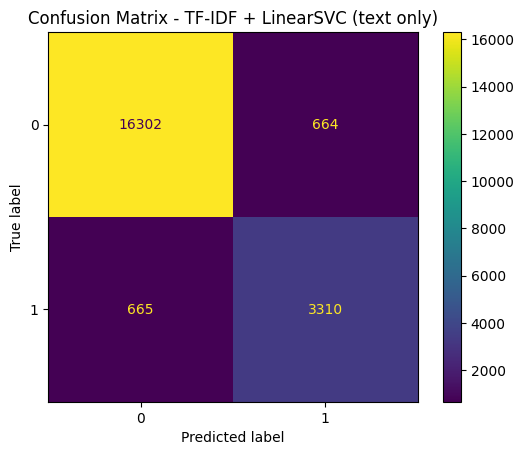

In [6]:
svm_clf = Pipeline(steps=[
    ("tfidf", TfidfVectorizer(
        max_features=50_000,
        ngram_range=(1, 2),
        min_df=5
    )),
    ("clf", LinearSVC(
        class_weight="balanced",
        random_state=42
    ))
])

svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_test)

print("Classification report (TF-IDF + LinearSVC):")
print(classification_report(y_test, y_pred_svm, digits=4))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm)
plt.title("Confusion Matrix - TF-IDF + LinearSVC (text only)")
plt.savefig('svm.png')
plt.show()

## Strukturált jellemzők hozzáadása

Ebben a részben a szöveges leírások mellett strukturált metaadatokat is felhasználunk a modell tanításához.  
A játékokhoz tartozó címkéket (tags) és műfajokat (genres) bináris (multi-hot) formában kódoljuk, majd ezeket a szöveges jellemzőkkel együtt használjuk fel az osztályozás során.


In [7]:
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
import re

# -------------------------------
# Segédfüggvény: split , ;
# -------------------------------
def split_multi(s):
    if pd.isna(s):
        return []
    parts = re.split(r"[;,]", str(s))
    return [p.strip().lower() for p in parts if p.strip()]

# -------------------------------
# TAGS előkészítése (top N)
# -------------------------------
gt = game_tag.merge(
    tags[["tagid", "tag_name"]],
    on="tagid",
    how="left"
)

gt["tag_norm"] = gt["tag_name"].astype(str).str.lower().str.strip()
gt = gt.dropna(subset=["tag_norm"]).drop_duplicates(subset=["appid", "tag_norm"])

TOP_N_TAGS = 300
top_tags = gt["tag_norm"].value_counts().head(TOP_N_TAGS).index.tolist()
gt = gt[gt["tag_norm"].isin(top_tags)]

tags_per_game = gt.groupby("appid")["tag_norm"].apply(list).reset_index()

mlb_tags = MultiLabelBinarizer()
tags_encoded = mlb_tags.fit_transform(tags_per_game["tag_norm"])

tags_df = pd.DataFrame(
    tags_encoded,
    columns=[f"tag_{t}" for t in mlb_tags.classes_]
)
tags_df["appid"] = tags_per_game["appid"]

# -------------------------------
# GENRES előkészítése (split , ;)
# -------------------------------
gg = game_genre.merge(
    genres[["genreid", "genre_name"]],
    on="genreid",
    how="left"
)

gg["genre_list"] = gg["genre_name"].apply(split_multi)

gg_exploded = (
    gg[["appid", "genre_list"]]
    .explode("genre_list")
    .dropna(subset=["genre_list"])
    .rename(columns={"genre_list": "genre_norm"})
    .drop_duplicates(subset=["appid", "genre_norm"])
)

MIN_GAMES_PER_GENRE = 50
vc = gg_exploded["genre_norm"].value_counts()
valid_genres = vc[vc >= MIN_GAMES_PER_GENRE].index
gg_exploded = gg_exploded[gg_exploded["genre_norm"].isin(valid_genres)]

genres_per_game = gg_exploded.groupby("appid")["genre_norm"].apply(list).reset_index()

mlb_genres = MultiLabelBinarizer()
genres_encoded = mlb_genres.fit_transform(genres_per_game["genre_norm"])

genres_df = pd.DataFrame(
    genres_encoded,
    columns=[f"genre_{g}" for g in mlb_genres.classes_]
)
genres_df["appid"] = genres_per_game["appid"]

# -------------------------------
# Strukturált feature-ök csatolása
# -------------------------------
df_feat = (
    df.merge(tags_df, on="appid", how="left")
      .merge(genres_df, on="appid", how="left")
)

new_feature_cols = [c for c in df_feat.columns if c.startswith("tag_") or c.startswith("genre_")]
df_feat[new_feature_cols] = df_feat[new_feature_cols].fillna(0).astype(int)

df_feat.head()


,appid,name,release_date,estimated_owners,required_age,price,dlc_count,num_recommendations,notes,website,...,genre_rpg,genre_sexual content,genre_simulation,genre_software training,genre_sports,genre_strategy,genre_utilities,genre_video production,genre_violent,genre_web publishing
0,10,Counter-Strike,2000-11-01,10000000 - 20000000,0.0,9.99,0.0,149445.0,Includes intense violence and blood.,NaN,...,0,0,0,0,0,0,0,0,0,0
1,20,Team Fortress Classic,1999-04-01,5000000 - 10000000,0.0,4.99,0.0,6454.0,Includes intense violence and blood.,NaN,...,0,0,0,0,0,0,0,0,0,0
2,30,Day of Defeat,2003-05-01,5000000 - 10000000,0.0,4.99,0.0,4032.0,NaN,http://www.dayofdefeat.com/,...,0,0,0,0,0,0,0,0,0,0
3,40,Deathmatch Classic,2001-06-01,5000000 - 10000000,0.0,4.99,0.0,2113.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,50,Half-Life: Opposing Force,1999-11-01,2000000 - 5000000,0.0,4.99,0.0,18908.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


## Kombinált modell (szöveg + tagek + műfajok)

Ebben a részben a TF-IDF szöveg-jellemzőket és a bináris strukturált jellemzőket (tagek, műfajok) együttesen használjuk fel az osztályozáshoz.


Classification report (combined | LogisticRegression):
              precision    recall  f1-score   support

           0     0.9748    0.9696    0.9722     16966
           1     0.8733    0.8928    0.8829      3975

    accuracy                         0.9551     20941
   macro avg     0.9240    0.9312    0.9276     20941
weighted avg     0.9555    0.9551    0.9553     20941



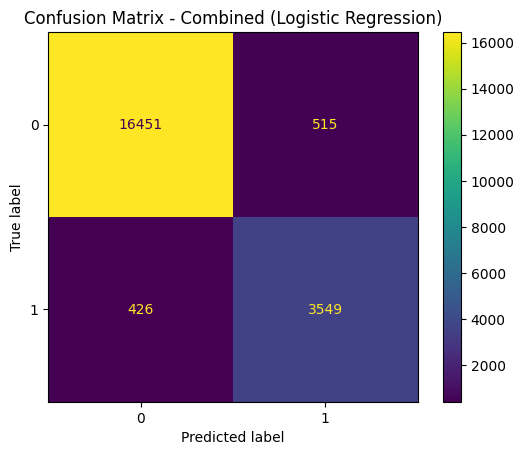

In [8]:
y = df_feat["y_multiplayer"].astype(int)
text_col = "text_clean"
structured_cols = [c for c in df_feat.columns if c.startswith("tag_") or c.startswith("genre_")]
X = df_feat[[text_col] + structured_cols].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

preprocess = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(max_features=50_000, ngram_range=(1, 2), min_df=5), text_col),
        ("struct", "passthrough", structured_cols),
    ],
    sparse_threshold=0.3
)

clf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=-1))
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Classification report (combined | LogisticRegression):")
print(classification_report(y_test, y_pred, digits=4))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix - Combined (Logistic Regression)")
plt.show()

## Kombinált modell (LinearSVC)

Ebben a részben a szöveges leírásokat és a strukturált jellemzőket együttesen felhasználva egy lineáris SVM modellt tanítunk.  
A lineáris SVM különösen jól teljesít nagy dimenziós, ritka bemeneteken, mint amilyenek a TF-IDF reprezentációk.


Classification report (Combined | LinearSVC):
              precision    recall  f1-score   support

           0     0.9720    0.9768    0.9744     16966
           1     0.8987    0.8797    0.8891      3975

    accuracy                         0.9584     20941
   macro avg     0.9354    0.9283    0.9318     20941
weighted avg     0.9581    0.9584    0.9582     20941



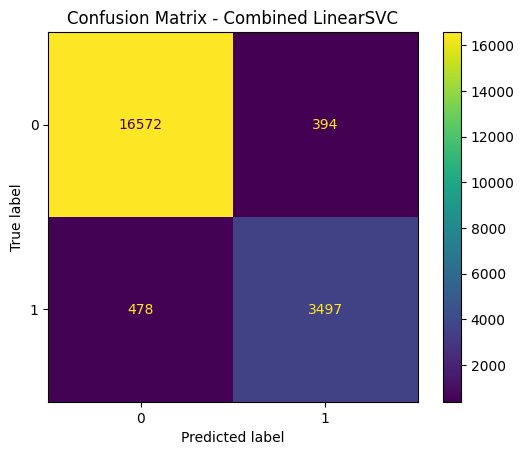

In [9]:
y = df_feat["y_multiplayer"].astype(int)

text_col = "text_clean"
structured_cols = [c for c in df_feat.columns if c.startswith("tag_") or c.startswith("genre_")]

X = df_feat[[text_col] + structured_cols].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

preprocess = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(
            max_features=50_000,
            ngram_range=(1, 2),
            min_df=5
        ), text_col),
        ("struct", "passthrough", structured_cols)
    ],
    sparse_threshold=0.3
)

svm_clf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LinearSVC(
        class_weight="balanced",
        random_state=42
    ))
])

svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)

print("Classification report (Combined | LinearSVC):")
print(classification_report(y_test, y_pred, digits=4))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix - Combined LinearSVC")
plt.show()